In [12]:
from vedo import *
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti
import numpy as np
import tensorflow as tf

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

from tensorflow.math import sin, cos, tan
import tensorflow_probability as tfp
import os
import mat4py
import matplotlib.pyplot as plt


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 180 seconds


In [ ]:
#read in raw PCAP files from Volpe
import velodyne_decoder as vd
config = vd.Config(model="VLP-16", rpm = 600)
pcap_file = '/media/derm/06EF-127D1/volpe/2021-03-10-16-43-50_Velodyne-VLP-16-Data_garminSignage.pcap'

cloud_arrays = []
for stamp, points in vd.read_pcap(pcap_file, config):
    cloud_arrays.append(points)

In [ ]:
from ICET_spherical import ICET
idx = 800 #frame idx
D  = True #draw scene
X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate

#cloud_arrays ..... [5622][x, y, z, intensity, ring, time]
pc1 = cloud_arrays[idx][:,:3]
pc2 = cloud_arrays[idx+1][:,:3]

it1 = ICET(cloud1 = pc1, cloud2 = pc2,  fid = 30, draw = D, x0 = X, 
           niter = 8, group= 2, RM = True, DNN_filter = False)
ViewInteractiveWidget(it1.plt.window)


In [ ]:
print(it1.X)
print(it1.pred_stds)

In [ ]:
from ICET_spherical import ICET

runlen = 5621
estimate_history = np.zeros([runlen,6])
pred_stds = np.zeros([runlen,6])

err_cnt = 0
X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate

for idx in range(400, runlen):
    
    print("\n --- idx ---", idx)
    
    #cloud_arrays ..... [5622][x, y, z, intensity, ring, time]
    pc1 = cloud_arrays[idx][:,:3]
    pc2 = cloud_arrays[idx+1][:,:3]

    try:
        it = ICET(cloud1 = pc1, cloud2 = pc2,  fid = 30, draw = False, x0 = X,
                   niter = 8, group= 2, RM = True, DNN_filter = False)

        estimate_history[idx,:] = it.X
        pred_stds[idx,:] = it.pred_stds
        
#         if it.X[0] > 0:
#             X = it.X
#         else:
#             X = tf.constant([0., 0., 0., 0., 0., 0.]) #initial transformation estimate
        
    except:
        print("ICET ERROR")
        err_cnt +=1
        
save_fn = "ICET_signage_fid30"
np.save(save_fn + "_estimates", estimate_history)
np.save(save_fn + "_pred_stds", pred_stds)

v1 .... mnp=50, fid=50, x0=0

(5621, 6)


<IPython.core.display.Javascript object>


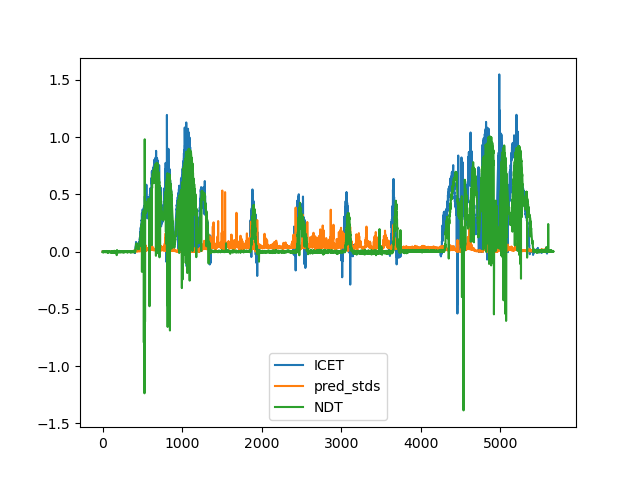

In [144]:
# estimate_history = np.load("ICET_signage_fid50_estimates.npy") 
estimate_history = np.load("ICET_signage_fid30_estimates.npy") #fid30 way better than fid50 for the 16 channel sensor
pred_stds = np.load("ICET_signage_fid30_pred_stds.npy")
# pred_stds = np.load("ICET_signage_fid50_estimates.npy") #debug
print(np.shape(estimate_history))

#load raw NDT results I generated using simple keyframing
# NDT_raw = np.loadtxt("NDT_results_pt5m_signage.txt")
NDT_raw = np.loadtxt("NDT_results_2m_signage.txt")
# NDT_raw = np.loadtxt("NDT_results_signage.txt")


#zero out negative forward movement
# estimate_history[estimate_history[:,0] < 0, 0] = 0
# NDT_raw[NDT_raw[:,1] < 0, 1] = 0

#suppress motion in periods where vehicle is parked 
estimate_history[1360:1850] = 0
estimate_history[1950:2400] = 0
estimate_history[2550:3000] = 0
estimate_history[3150:3600] = 0
estimate_history[3750:4250] = 0


component = 0 #x
# component = 5 #yaw

fig, ax = plt.subplots()
ax.plot(estimate_history[:,component], label = "ICET")
ax.plot(pred_stds[:,component], label = "pred_stds")
vf = np.sqrt(estimate_history[:,0]**2 + estimate_history[:,1]**2)
# ax.plot(vf, label = "total vf ICET")
ax.plot(NDT_raw[:,1], label = "NDT")
ax.legend(loc = "best")


# Plot East/ North trajectory of ground truth, NDT, and ICET

(1693, 3)
(2851, 7)


<IPython.core.display.Javascript object>


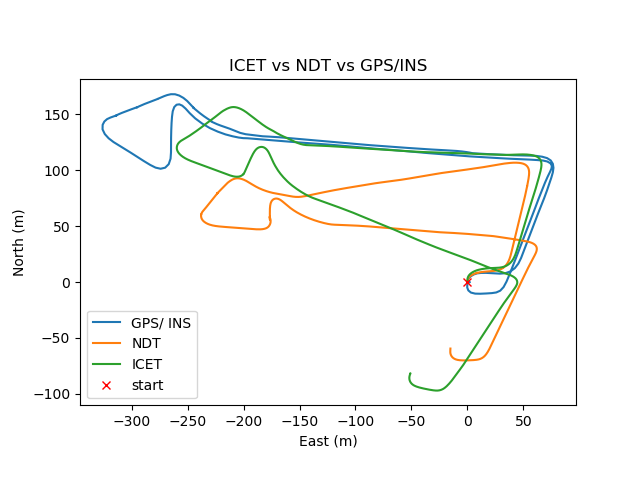

In [145]:
#load MatLab files
cwd = os.getcwd()
vp = os.path.dirname(os.path.realpath(cwd)) + "/volpe/" #Volpe Path

gtfn = vp + "gps_enu.mat"
gt = np.transpose(mat4py.loadmat(gtfn)['gps_enu']) 
print(np.shape(gt))

NDTfn = vp + "pos_lidar_enu.mat"
NDT = np.asarray(mat4py.loadmat(NDTfn)['pos_lidar_enu'])
print(np.shape(NDT))

# -----------------------------------------------
# print(np.shape(estimate_history))
ICET_total = np.zeros(np.shape(estimate_history))
NDT_total = np.zeros(np.shape(NDT_raw))
for i in range(np.shape(estimate_history)[0]):
    ICET_total[i] = np.sum(estimate_history[:i], axis = 0)
    NDT_total[i] = np.sum(NDT_raw[:i], axis = 0)

ICET_total[:,5] += np.deg2rad(90) #set initial rotation
NDT_total[:,5] += np.deg2rad(90)
    
#need to combine TOTAL heading with incremental changes in x and y (really should be ignoring y...)
ICET_traj = np.zeros([np.shape(estimate_history)[0], 2])
NDT_traj = np.zeros([np.shape(estimate_history)[0], 2])

for j in range(1, np.shape(estimate_history)[0]):
    #x[i] = x[i-1] + step_dist*cos(heading)z
    ICET_traj[j,0] = ICET_traj[j-1,0] +estimate_history[j,0]*np.cos(ICET_total[j,5])
#     ICET_traj[j,0] = ICET_traj[j-1,0] + vf[j]*np.cos(ICET_total[j,5])
    NDT_traj[j,0] = NDT_traj[j-1,0] + NDT_raw[j,1]*np.cos(-NDT_total[j,3])

    #y[i] = y[i-1] + step_dist*sin(heading)
    ICET_traj[j,1] = ICET_traj[j-1,1] + estimate_history[j,0]*np.sin(ICET_total[j,5])
#     ICET_traj[j,1] = ICET_traj[j-1,1] + vf[j]*np.sin(ICET_total[j,5])
    NDT_traj[j,1] = NDT_traj[j-1,1] + NDT_raw[j,1]*np.sin(-NDT_total[j,3])

# -----------------------------------------------

#plot xy total positions
fig, ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.set_xlabel("East (m)")
ax.set_ylabel("North (m)")
ax.set_title("ICET vs NDT vs GPS/INS")

font = {'fontname':'Times New Roman'}
ax.plot(-gt[:,0], -gt[:,1], label = "GPS/ INS")
# ax.plot(NDT[:,0], NDT[:,1], label = "NDT (Tuned)") #using pre-made NDT trajectory
ax.plot(-NDT_traj[:,1], NDT_traj[:,0], label = "NDT") #debug NDT trajectory inherited from MatLab code"
ax.plot(ICET_traj[:,0], ICET_traj[:,1], label = "ICET")
ax.plot(0, 'rx', label = "start")
ax.legend(loc = 'best')

In [137]:
#TODO: get ground truth forward translation and rotation from GNSS ENU data
gt_vf = np.sqrt(gt[:,0]**2 + gt[:,1]**2)

gt_cum = np.zeros(np.shape(gt_vf))
for i in range(len(gt_cum)):
    gt_cum[i] = np.sum(gt_vf[:i])


<IPython.core.display.Javascript object>


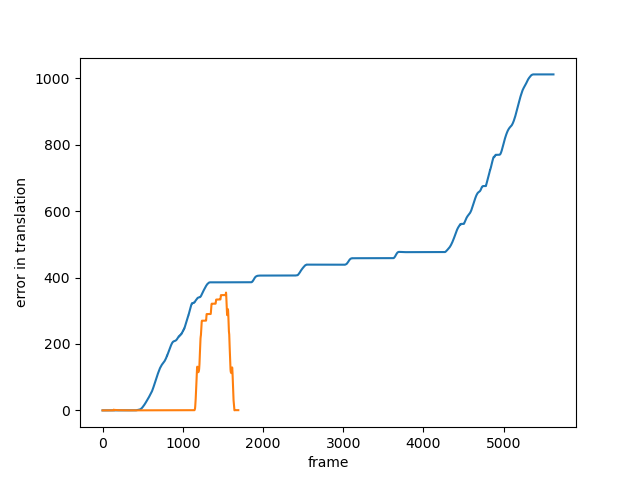

In [146]:
#plot total forward translation of ICET with error bounds

fig, ax = plt.subplots()
ax.set_xlabel("frame")
ax.set_ylabel("error in translation")

ax.plot(ICET_total[:,0])
ax.plot(gt_vf)

In [124]:
#TEST- load liar velocity estimated by Volpe
import pandas as pd
from scipy.spatial.transform import Rotation

volpe_lidar_raw = vp + "relPos_lidar.mat"
NDT_raw = np.asarray(mat4py.loadmat(volpe_lidar_raw)['relPos_lidar'])#[:,:3]
NDT_trans = NDT_raw[:,:3]

#not sure why this file is half the length of the full rel pos...
# volpe_lidar_raw_rot = vp + "yaw_lidar.mat"
# NDT_rot = np.asarray(mat4py.loadmat(volpe_lidar_raw_rot)['yaw_lidar'])
# print(np.shape(NDT_rot))

rot = Rotation.from_quat(NDT_raw[1:,3:])
rot_euler = rot.as_euler('xyz', degrees=True)
NDT_rot = pd.DataFrame(data=rot_euler, columns=['x', 'y', 'z']).to_numpy()

print(np.shape(NDT_trans))
print(np.shape(NDT_rot))

print(NDT_trans[2500])

(5670, 3)
(5669, 3)
[-0.03935342  0.36233065  0.00870829]
